<a href="https://colab.research.google.com/github/nadiaaaa95/car-damage/blob/main/damage_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data into data1a - Whole(train and validation) or Damaged(train and validation)


In [ ]:
import urllib.request
import pickle
import matplotlib.pyplot as plt
from IPython.display import display,Image,clear_output
import numpy as np
import os
import h5py
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report,confusion_matrix
from collections import Counter,defaultdict

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.models import Sequential, load_model,Model
from keras.layers import Dense, Flatten, Dropout, Activation, add
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.utils.np_utils import to_categorical
from keras.utils import get_file
from keras import optimizers
from keras.regularizers import l1, l2
from keras.callbacks import ModelCheckpoint, History

Using TensorFlow backend.
/home/akash/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
from keras import backend as K
K.backend()

'tensorflow'

In [ ]:
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('vgg16_weights.h5', WEIGHTS_PATH_NO_TOP)

### Defining input data

In [ ]:
# path to the model weights file
location = './car-damage-dataset/data1a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
val_data_dir = location+'/validation'

train_samples = [len(os.listdir(os.path.join(train_data_dir,i))) for i in os.listdir(train_data_dir)]
nb_train_samples = sum(train_samples)
val_samples = [len(os.listdir(os.path.join(val_data_dir,i))) for i in os.listdir(val_data_dir)]
nb_val_samples = sum(val_samples)

nb_epoch = 50

In [ ]:
train_samples

[920, 920]

In [ ]:
K.image_data_format()

'channels_last'

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)    # img_width first or img_height

In [ ]:
input_shape

(256, 256, 3)

In [ ]:
# def load_vgg16(weights_path='../vgg16_weights.h5'):
#     model = Sequential()
#     model.add(ZeroPadding2D(padding=(1,1),input_shape=(224,224,3)))   # for best performance you should set
#                                                                       # `image_data_format='channels_last'` 
#                                                                       # in your Keras config
#                                                                       # at ~/.keras/keras.json.
#     model.add(Convolution2D(filters=64, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=64, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=128, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=128, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=256, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(ZeroPadding2D(padding=(1,1)))
#     model.add(Convolution2D(filters=512, kernel_size=3, strides=3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     # assert os.path.exists(weights_path), 'Model weights not found (see "weights_path")'
    
#     # Use below code to freeze the conv model i.e. its learning
#     '''
#     for layer in model.layers:
#         layer.trainable = False
#     '''
    
#     if weights_path:
#     # note: this chops off the last layers of VGG16 

#     # loads the weights of the VGG16 networks
#     # NOTE: when there is a complete match between model definition
#     # and your weights savefile, you can simply call model.load_weights(filename)    
#         f = h5py.File(weights_path)

#         # LEFT CURRENTLY

In [ ]:
# if(os.path.exists(location+'vgg16.h5')):
#     base_model = load_model('vgg16.h5')
# else:
#     base_model = VGG16(weights='imagenet')
#     base_model.save(location)

KeyboardInterrupt: 

In [ ]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=input_shape ,pooling=max)

In [ ]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [ ]:
# Set base_model layers to non-trainable
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [ ]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [ ]:
def save_bottleneck_features(location):    # SAMAJANA
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    
    if(os.path.exists(location+'/bottleneck_features_train.npy')):
        print('Already exists',location+'/bottleneck_features_train.npy')
    else:
        train_generator = datagen.flow_from_directory(train_data_dir,
                                                      target_size=(img_height,img_width),
                                                      batch_size=16,
                                                      class_mode=None,         # only data, no labels
                                                      shuffle=False)           # keep data in same order as labels
    
        bottleneck_features_train = base_model.predict_generator(train_generator,
                                                                 nb_train_samples // 16,
                                                                 verbose=1)
        
        print('Saving',location+'/bottleneck_features_train.npy')
        np.save(open(location+'/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
        #np.save(location+'/bottleneck_features_train.npy',bottleneck_features_train)
    
    if(os.path.exists(location+'/bottleneck_features_val.npy')):
        print('Already exists',location+'/bottleneck_features_val.npy')
    else:
        # Repeat it with validation data
        val_generator = datagen.flow_from_directory(val_data_dir,
                                                    target_size=(img_height,img_width),
                                                    batch_size=16,
                                                    class_mode=None,
                                                    shuffle=False)

        bottleneck_features_val = base_model.predict_generator(val_generator,
                                                               nb_val_samples / 16,
                                                               verbose=1)
        print('Saving',location+'/bottleneck_features_val.npy')
        np.save(open(location+'/bottleneck_features_val.npy','wb'),bottleneck_features_val)
        #np.save(location+'/bottleneck_features_val.npy',bottleneck_features_train)

In [ ]:
val_labels = np.array([0]*val_samples[0] +
                          [1]*val_samples[1])

In [ ]:
train_data = np.load(open(location+'/bottleneck_features_train.npy', 'rb'))

In [ ]:
train_data.shape

(1840, 8, 8, 512)

In [ ]:
val_data = np.load(open(location+'/bottleneck_features_val.npy', 'rb'))
val_data.shape

(460, 8, 8, 512)

In [ ]:
def train_binary_model(location):
    train_data = np.load(open(location+'/bottleneck_features_train.npy', 'rb'))
    print(train_data.shape[1:])
    train_labels = np.array([0]*train_samples[0]+ 
                            [1]*train_samples[1])

    val_data = np.load(open(location+'/bottleneck_features_val.npy', 'rb'))
    val_labels = np.array([0]*val_samples[0] +
                          [1]*val_samples[1])

    model = Sequential()
    model.add(Flatten(input_shape=(train_data.shape[1:])))     # 8, 8, 512
    model.add(Dense(units=256, activation='relu',
                    kernel_regularizer=l2(l=0.01)))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),    # check the lr
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, 
                                 monitor='val_acc', 
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True, 
                                 mode='auto')     # ?read documentation

    fit = model.fit(train_data, train_labels, epochs=nb_epoch, batch_size=16,
                    validation_data=(val_data, val_labels), callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

In [ ]:
# # either bottleneck or this

# top_model = Sequential()
# top_model.add(Conv2D(32, (3, 3), input_shape=input_shape))
# top_model.add(Activation('relu'))
# top_model.add(MaxPooling2D(pool_size=(2, 2)))

# top_model.add(Conv2D(32, (3, 3)))
# top_model.add(Activation('relu'))
# top_model.add(MaxPooling2D(pool_size=(2, 2)))

# top_model.add(Conv2D(64, (3, 3)))
# top_model.add(Activation('relu'))
# top_model.add(MaxPooling2D(pool_size=(2, 2)))

# top_model = Sequential()
# top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
# top_model.add(Dense(units=256,activation='relu',kernel_regularizer=l2(l=0.01)))
# top_model.add(Dropout(rate=0.5))
# top_model.add(Dense(units=1,activation='sigmoid'))

# top_model.compile(optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),    # check the lr
#                   loss='binary_crossentropy',
#                  metrics = ['accuracy'])

# # prepare data augmentation configuration
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=40,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')

# # this is the augmentation configuration we will use for testing:
# # only rescaling
# test_datagen = ImageDataGenerator(rescale=1. / 255)

# train_generator = train_datagen.flow_from_directory(train_data_dir,
#                                                     target_size=(img_height, img_width),
#                                                     batch_size=8,
#                                                     class_mode='binary')   # categorical for multiclass
    
# test_generator = test_datagen.flow_from_directory(val_data_dir,
#                                                   target_size=(img_height, img_width),
#                                                   batch_size=8,
#                                                   class_mode='binary',     # categorical for multiclass
#                                                   shuffle=False)

# model.fit_generator(
#     train_generator,
#     steps_per_epoch=nb_train_samples // 8,
#     epochs=nb_epoch,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples // 8)

# model.save_weights(top_model_weights_path)

In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(units=256,activation='relu',kernel_regularizer=l2(l=0.01)))
top_model.add(Dropout(rate=0.5))
top_model.add(Dense(units=1,activation='sigmoid'))
    
top_model.load_weights(top_model_weights_path) # load weights_path
    
#base_model.add(top_model)
    
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
print(model.layers[-1].get_weights())
print(top_model.get_weights())
model.summary()

[array([[-0.01012065, -0.01048303,  0.0032335 , ...,  0.00972222,
        -0.01335548, -0.01087625],
       [ 0.00905526, -0.00504446, -0.00211019, ...,  0.00015012,
        -0.00304197,  0.00717667],
       [ 0.01050402, -0.00598194,  0.01128646, ...,  0.00608847,
         0.00694825, -0.00326765],
       ..., 
       [ 0.00228057,  0.00289785, -0.00409706, ..., -0.0096005 ,
        -0.01046735,  0.00817893],
       [-0.00052284, -0.00416786, -0.00747126, ..., -0.00335509,
         0.01101705, -0.00097601],
       [-0.00150657,  0.00663762, -0.00871113, ..., -0.00802929,
        -0.00821638, -0.00677615]], dtype=float32), array([ -6.63930041e-05,  -6.27243571e-05,  -4.21339973e-05,
        -3.36487865e-05,  -1.31908173e-05,   1.40916454e-04,
         3.21922744e-05,  -9.27699875e-05,  -1.64583562e-05,
        -7.52625201e-05,  -6.59315119e-05,   6.05078058e-05,
        -4.62493745e-06,   2.27251494e-05,  -1.93112064e-05,
        -1.38478526e-05,  -2.43670002e-05,   2.52712562e-05,
   

In [ ]:
def finetune_binary_model(location):
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(units=256,activation='relu',kernel_regularizer=l2(l=0.01)))
    top_model.add(Dropout(rate=0.5))
    top_model.add(Dense(units=1,activation='sigmoid'))
    
    top_model.load_weights(top_model_weights_path) # load weights_path
    
    #base_model.add(top_model)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    #model.add(top_model)
    
#     input1 = keras.layers.Input(shape=(16,))
#     x1 = keras.layers.Dense(8, activation='relu')(input1)
#     input2 = keras.layers.Input(shape=(32,))
#     x2 = keras.layers.Dense(8, activation='relu')(input2)
#     added = keras.layers.add([x1, x2])

#     out = keras.layers.Dense(4)(added)
#     model = keras.models.Model(inputs=[input1, input2], outputs=out)

#     # finetune
#     top_model = Sequential()
#     top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
#     top_model.add(Dense(256, activation='relu'))
#     top_model.add(Dropout(0.5))
#     top_model.add(Dense(6, activation='sigmoid'))
#     top_model.load_weights(top_model_weights_path)

#     model = Model(input= base_model.input, output= top_model(model.output))
#     model.add(top_model)

    
#     # set the first 25 layers (up to the last conv block)
#     # to non-trainable - weights will not be updated
#     for layer in model.layers[:25]:
#         layer.trainable=False

    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    model.compile(optimizer=optimizers.SGD(lr=0.00001,momentum=0.9),    # reduced learning rate by 1/10
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=8,
                                                        class_mode='binary')   # categorical for multiclass
    
    test_generator = test_datagen.flow_from_directory(val_data_dir,
                                                      target_size=(img_height, img_width),
                                                      batch_size=8,
                                                      class_mode='binary',     # categorical for multiclass
                                                      shuffle=False)
    
    checkpoint = ModelCheckpoint(filepath=fine_tuned_model_path,monitor='val_acc',verbose=1,save_best_only=True,
                                 save_weights_only=False,mode='auto')
    
    # fine-tune the model
    fit = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples/8,
                              #epochs=nb_epoch,
                              epochs=10,
                              validation_data=test_generator,
                              validation_steps=nb_val_samples/8,
                              verbose=1,
                              callbacks=[checkpoint])

#     model.fit_generator(
#     train_generator,
#     steps_per_epoch=nb_train_samples // batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples // batch_size,
#     verbose=2)
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [ ]:
def evaluate_binary_model(model,directory,labels):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
    test_generator = test_datagen.flow_from_directory(directory,
                                                     target_size=(img_height,img_width),
                                                     batch_size=8,
                                                     class_mode='binary',     # categorical for multiclass
                                                     shuffle=False)
    
    predictions = model.predict_generator(test_generator,
                                          steps=len(labels)/8,
                                          verbose=1)   
    
    # use for multiclass
    # pred_labels = np.argmax(predictions, axis=1)
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print()
    print(classification_report(labels, pred_labels))
    print()
    cm = confusion_matrix(labels, pred_labels)
#     sns.heatmap(cm, annot=True, fmt='g');
    return cm

In [ ]:
def view_images(img_dir,img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img,width=200))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1,', val_acc:', model_hist['val_acc'][best_epoch],', val_loss:', 
          model_hist['val_loss'][best_epoch])

In [ ]:
def plot_metrics(hist, stop=50):  # stop -> no of data pts in plot
                                # hist(history) -> dict
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    # axes = axes.flatten()   # flatten -> numpy flatten

    ax0.plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    ax0.plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    ax0.set_title('Accuracy')
    ax0.set_ylabel('Accuracy')
    ax0.set_xlabel('Epoch')
    ax0.legend(loc='lower right')

    ax1.plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    ax1.plot(range(stop), hist['val_loss'],
             label='Validation', color='#03507E')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')

    plt.tight_layout()

    print("Best Model: ")
    print_best_model_results(hist)

### Testing Image Generation

In [ ]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

img = load_img(path='./car-damage-dataset/data1a/training/00-damage/0354.JPEG')  # this is a PIL image
x = img_to_array(img)   # x shape (height,width,3)
x = x.reshape((1,)+x.shape)  # this is a numpy array of shape (1,height,width,3)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the 'preview/' directory
if not os.path.exists('./car-damage-dataset/data1a_preview'):
    os.makedirs('./car-damage-dataset/data1a_preview')
i = 0 
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='./car-damage-dataset/data1a_preview', save_prefix='damage_car',
                         save_format='jpeg'):
    i +=1
    if i > 30:
        break # otherwise the generator would loop indefinitely

In [ ]:
view_images('./car-damage-dataset/data1a_preview/',os.listdir('./car-damage-dataset/data1a_preview'))

### Training

In [ ]:
# do not rerun!!
save_bottleneck_features(location)

Already exists ./car-damage-dataset/data1a/bottleneck_features_train.npy
Already exists ./car-damage-dataset/data1a/bottleneck_features_val.npy


In [ ]:
sns.set_style('whitegrid')

In [ ]:
d1a_model1,d1a_history1 = train_binary_model(location)

In [ ]:
# Winner
plot_metrics(d1a_history1)  # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

### Fine Tuning

In [ ]:
ft_model,ft_history = finetune_binary_model(location)

In [ ]:
# Winner
plot_metrics(ft_history,stop=10)   # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

### Load Modal Point

In [ ]:
ft_model = load_model(location+'/ft_model.h5')

In [ ]:
with open(location+'/top_history.txt') as f:
    top_history = json.load(f)

Best Model: 
epoch: 23 , val_acc: 0.95 , val_loss: 5.388070894324261


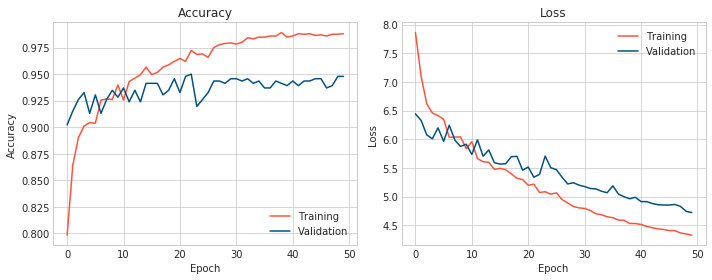

In [ ]:
plot_metrics(top_history)

In [ ]:
with open(location+'/ft_history.txt') as f:
    ft_history = json.load(f)

Best Model: 
epoch: 7 , val_acc: 0.9043478260869565 , val_loss: 5.6756150121274205


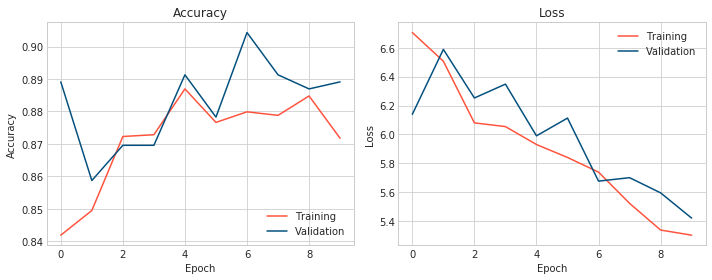

In [ ]:
plot_metrics(ft_history,stop=10)

In [ ]:
def plot_acc_metrics(hist1,hist2,stop1=50,stop2=10):
    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(5,6))
    axes = axes.flatten()
    
    axes[0].plot(range(stop1),hist1['acc'],label='training',color='#FF533D')
    axes[0].plot(range(stop1),hist1['val_acc'],label='validation',color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    
    axes[1].plot(range(stop2),hist2['acc'],label='training',color='#FF533D')
    axes[1].plot(range(stop2),hist2['val_acc'],label='validation',color='#03507E')
    axes[1].set_title('Fine-Tuning')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuarcy')
    axes[1].legend(loc='lower right')
    
    plt.tight_layout()

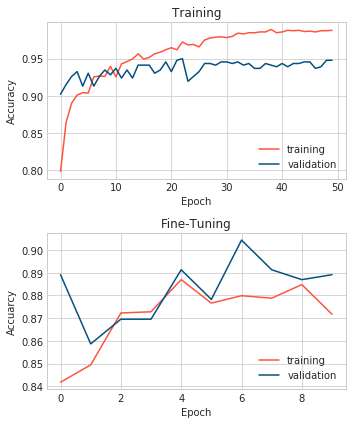

In [ ]:
plot_acc_metrics(top_history,ft_history)

In [ ]:
cm = evaluate_binary_model(ft_model,val_data_dir,val_labels)

Found 460 images belonging to 2 classes.
58/57 [==============================] - 534s 9s/step

             precision    recall  f1-score   support

          0       0.97      0.83      0.90       230
          1       0.85      0.97      0.91       230

avg / total       0.91      0.90      0.90       460




In [ ]:
heatmap_labels = ['damaged','whole']

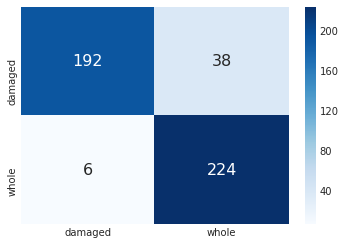

In [ ]:
sns.heatmap(cm,annot=True,annot_kws={"size":16},
           fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

### Making live predictions

In [ ]:
def car_categories_gate(img_url,model):
    urllib.request.urlretrieve(img_url,'save_second_gate.jpg')
    img = load_img('save_second_gate.jpg',target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    pred = model.predict(x)
    print("Validating that damage exists...")
    #print(pred)
    if pred[0][0] <=.5:
        print("Validation complete - proceed to location and severity determination")
    else:
        print("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print("Hint: Try zooming in/out, using a different angle or different lighting")

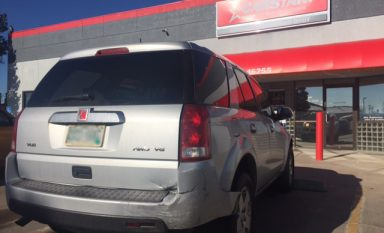

In [ ]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [ ]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

Validating that damage exists...
Validation complete - proceed to location and severity determination


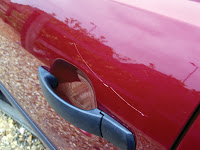

In [ ]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [ ]:
car_categories_gate('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

Validating that damage exists...
Validation complete - proceed to location and severity determination


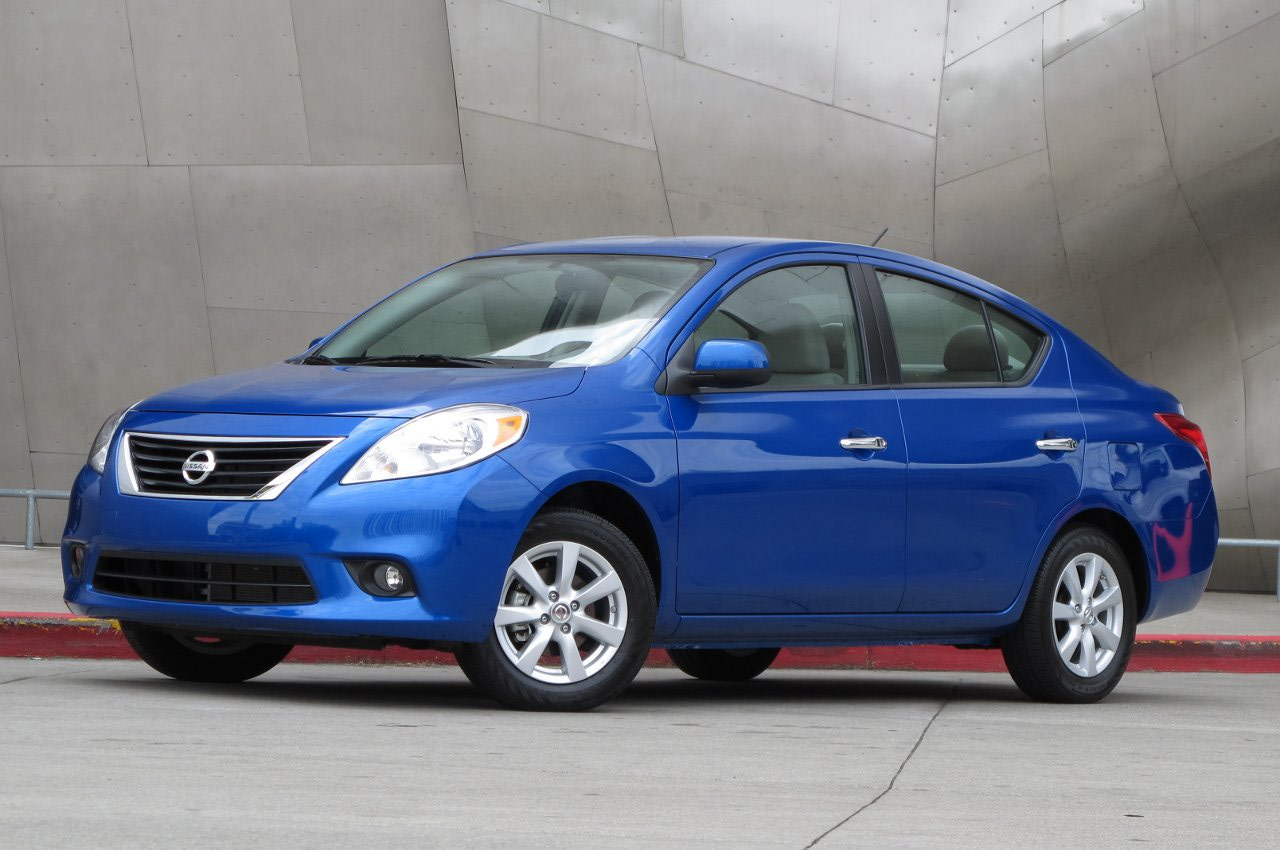

In [ ]:
Image('https://i.pinimg.com/originals/00/e2/d2/00e2d282c9d51424c5c3a96e9e649e37.jpg')

In [ ]:
car_categories_gate('https://i.pinimg.com/originals/00/e2/d2/00e2d282c9d51424c5c3a96e9e649e37.jpg',ft_model)

Validating that damage exists...
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting
